Материалы Ульянкина Ф.В. (YouTube-канал «Прикладная статистика» ВШЭ)



#  SARIMA

In [1]:
import numpy as np # для мат. операций
import pandas as pd # для работы с данными (числовые таблицы и временные ряды)

import matplotlib.pyplot as plt # для построения графиков
from sktime.utils.plotting import plot_series # для построения графиков

from statsmodels.tsa.stattools import adfuller, kpss # для оценки стационарности


In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 # средняя абсолютная ошибка в процентах 


<img src="MAPE.png" height="100"> 


# Данные


In [99]:
parser = lambda x: pd.to_datetime(x, format='%d.%m.%Y %H:%M')
EnCons = pd.read_csv('PJMW_hourly_Short.csv', sep=';', index_col=['Time'], parse_dates=['Time'], date_parser=parser)
print(EnCons.shape)
EnCons.head()

(144, 1)


,PJMW_MW
Time,
2017-04-24 00:00:00,4166
2017-04-24 01:00:00,4005
2017-04-24 02:00:00,3956
2017-04-24 03:00:00,3948
2017-04-24 04:00:00,3990


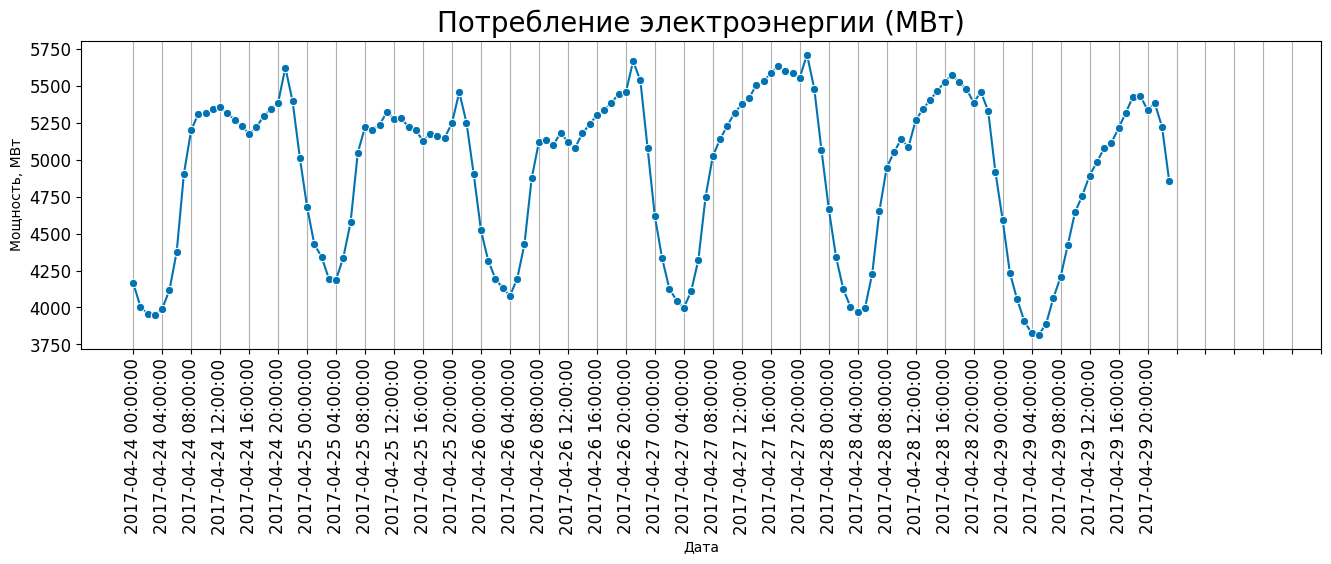

In [101]:
y = EnCons.PJMW_MW

plot_series(y)
plt.title('Потребление электроэнергии (МВт)', fontsize=20, color='black');
plt.tick_params(axis = 'both', which = 'major', labelsize = 12);
plt.xlabel('Дата');
plt.ylabel('Мощность, МВт');
plt.grid ( axis='x' );
plt.xticks(np.arange(0, 168, 4));
plt.xticks(rotation=90);

Тесты выдают не только `p_value`, но и критические значения. У тестов нестандартные распределения. Число лагов для тестирования подбирается автоматически по информационному критерию. 

In [102]:
adfuller(y, regression='c', autolag='AIC')

(-6.201779864085484,
 5.783793117537213e-08,
 14,
 129,
 {'1%': -3.482087964046026,
  '5%': -2.8842185101614626,
  '10%': -2.578864381347275},
 1576.533032405931)

In [103]:
kpss(y, regression='c')

(0.03625002999770088,
 0.1,
 7,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Тесты можно проводить против разных альтернатив, в зависимости от того, что мы видим в данных: 

```
    * "c" : constant only (default).
    * "ct" : constant and trend.
    * "ctt" : constant, and linear and quadratic trend.
    * "n" : no constant, no trend.
```

В данном случае мы видим только константу, так как ряд колеблется вокруг ненулевого среднего.

# 3. Автоарима

Попробуем оценить на наших данных SARIMA-модель. Делать это будем в рамках [пакета `pmdarima`](https://alkaline-ml.com/pmdarima/user_guide.html)

120 24


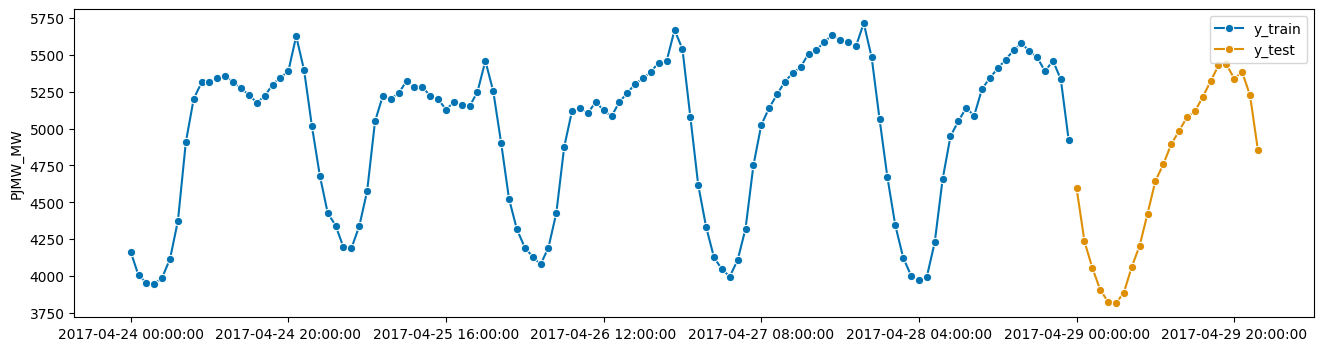

In [104]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon

y_train, y_test = temporal_train_test_split(y, test_size=24)
fh = ForecastingHorizon(y_test.index, is_relative=False)

plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

In [105]:
import pmdarima as pm
from pmdarima import model_selection

arima_model = pm.auto_arima(
    
    y_train,
    start_p=1, start_q=1,
    max_p=5, max_q=5, 
    
    seasonal=True, m=24,
    start_P=0, start_Q=0,
    max_P = 2, max_Q = 2,
    
    max_D=2, max_d=2,
    alpha=0.05,
    test='kpss',
    seasonal_test='ocsb',    
    
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=False, 
    n_fits=100,
    information_criterion='bic',
    out_of_sample_size=7
)

 ARIMA(0,0,0)(0,1,0)[24] intercept   : BIC=1263.735, Time=0.05 sec
 ARIMA(0,0,0)(0,1,1)[24] intercept   : BIC=1262.410, Time=0.52 sec
 ARIMA(0,0,0)(0,1,2)[24] intercept   : BIC=1265.272, Time=1.82 sec
 ARIMA(0,0,0)(1,1,0)[24] intercept   : BIC=1264.025, Time=0.51 sec
 ARIMA(0,0,0)(1,1,1)[24] intercept   : BIC=inf, Time=1.06 sec
 ARIMA(0,0,0)(1,1,2)[24] intercept   : BIC=inf, Time=3.30 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : BIC=1264.750, Time=1.63 sec
 ARIMA(0,0,0)(2,1,1)[24] intercept   : BIC=inf, Time=2.83 sec
 ARIMA(0,0,0)(2,1,2)[24] intercept   : BIC=inf, Time=3.05 sec
 ARIMA(0,0,1)(0,1,0)[24] intercept   : BIC=1179.660, Time=0.18 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : BIC=1178.672, Time=0.83 sec
 ARIMA(0,0,1)(0,1,2)[24] intercept   : BIC=1181.751, Time=2.07 sec
 ARIMA(0,0,1)(1,1,0)[24] intercept   : BIC=1179.946, Time=0.71 sec
 ARIMA(0,0,1)(1,1,1)[24] intercept   : BIC=inf, Time=0.95 sec
 ARIMA(0,0,1)(1,1,2)[24] intercept   : BIC=inf, Time=3.00 sec
 ARIMA(0,0,1)(2,1,0)[24] 

In [106]:
print(arima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 24)   Log Likelihood                -527.605
Date:                            Sun, 02 Jun 2024   AIC                           1063.209
Time:                                    01:53:11   BIC                           1073.466
Sample:                                         0   HQIC                          1067.355
                                            - 120                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7869      6.181      0.127      0.899     -11.327      12.901
ar.L1          0.8956      0.042   

In [107]:
y_pred, pred_ci = arima_model.predict(
    n_periods=24, 
    return_conf_int=True, 
    alpha=0.05
)

mape(y_pred, y_test)

4.8540399751109815

In [108]:
df_forecast = pd.DataFrame({'y_pred': y_pred, 'ci_lower': pred_ci[:,0], 'ci_upper': pred_ci[:,1]})
df_forecast.index = y_test.index
print(df_forecast)

                          y_pred     ci_lower     ci_upper
2017-04-29 00:00:00  4526.623340  4412.491547  4640.755133
2017-04-29 01:00:00  4223.965364  4070.748709  4377.182018
2017-04-29 02:00:00  4021.345457  3842.858578  4199.832337
2017-04-29 03:00:00  3919.002559  3722.580474  4115.424644
2017-04-29 04:00:00  3894.563532  3684.860018  4104.267045
2017-04-29 05:00:00  3946.242938  3726.464696  4166.021181
2017-04-29 06:00:00  4182.518092  3954.980298  4410.055886
2017-04-29 07:00:00  4618.273712  4384.697602  4851.849822
2017-04-29 08:00:00  4913.504610  4675.195240  5151.813980
2017-04-29 09:00:00  5025.050857  4783.011449  5267.090266
2017-04-29 10:00:00  5120.889112  4875.898581  5365.879643
2017-04-29 11:00:00  5101.019851  4853.687434  5348.352269
2017-04-29 12:00:00  5260.833537  5011.638408  5510.028666
2017-04-29 13:00:00  5333.463322  5082.783965  5584.142680
2017-04-29 14:00:00  5406.350992  5154.487335  5658.214649
2017-04-29 15:00:00  5462.210022  5209.400351  5715.0196

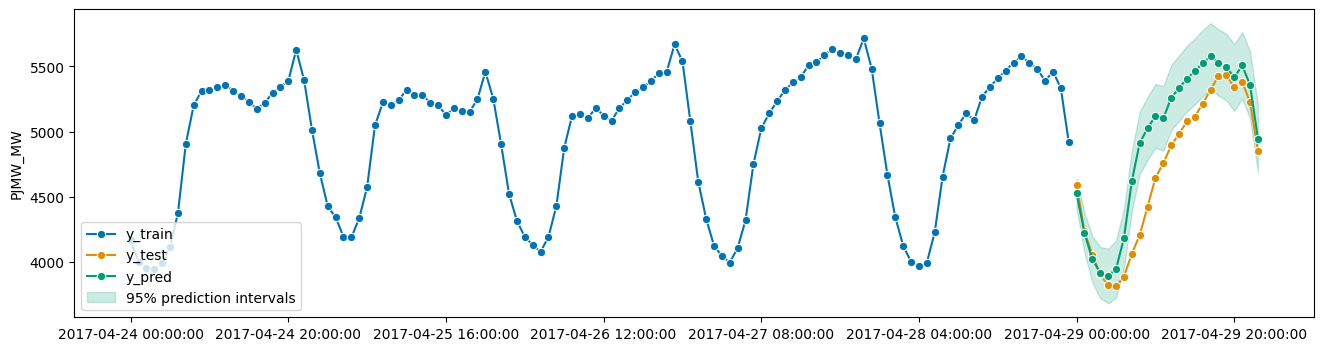

In [109]:
fig, ax = plot_series(y_train, y_test, df_forecast.y_pred, labels=["y_train", "y_test", "y_pred"]);
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    df_forecast["ci_lower"],
    df_forecast["ci_upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"95% prediction intervals",
)
ax.legend(loc='lower left');

Посмотрим на графики для диагностики модели. Автокорреляций нет, математическое ожидание равно нулю. Дисперсия постоянна. Распределение остатков нормально. Приятно. 

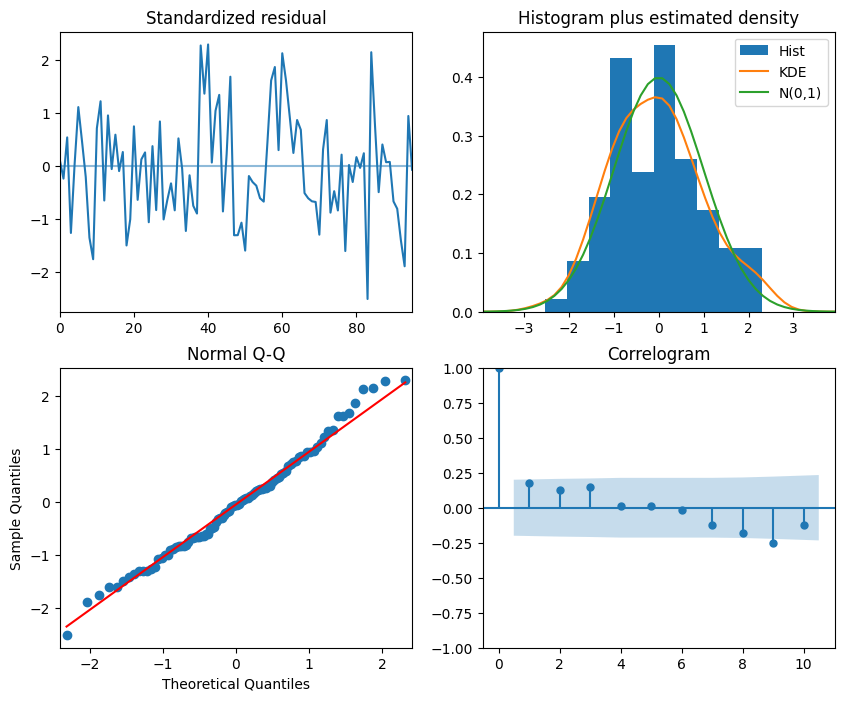

In [110]:
arima_model.plot_diagnostics(figsize=(10, 8));

На самом деле ровно эта же модель вшита в пакет `sktime`, но в урезанном виде. Напомню, что этот пакет только разрабатывается и его великое будущее впереди. 

# 4. Трансформация данных 

В рамках пакета можно делать трансформацию данных и собирать пайплайны также, как и в sklearn. Например, перед обучением модели можно сделать преобразование Бокса-Кокса. Его здесь обычно используют для того, чтобы стабилизировать дисперсию остатков и сделать их нормальными. 

In [111]:
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

pipeline = Pipeline([
    ("boxcox", BoxCoxEndogTransformer()),
    ("model", pm.auto_arima(
    
    y_train,
    start_p=1, start_q=1,
    max_p=5, max_q=5, 
    
    seasonal=True, m=24,
    start_P=0, start_Q=0,
    max_P = 2, max_Q = 2,
    
    max_D=2, max_d=2,
    alpha=0.05,
    test='kpss',
    seasonal_test='ocsb',    
    
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=False, 
    n_fits=100,
    information_criterion='bic',
    out_of_sample_size=7
    
    # Можно делать перебор гипер-параметров 
    # на основе метрики на тестовой выборке
    #scoring='mae',
))
])

res = pipeline.fit(y_train)
pipeline.predict(5)

 ARIMA(0,0,0)(0,1,0)[24] intercept   : BIC=1263.735, Time=0.03 sec
 ARIMA(0,0,0)(0,1,1)[24] intercept   : BIC=1262.410, Time=0.54 sec
 ARIMA(0,0,0)(0,1,2)[24] intercept   : BIC=1265.272, Time=2.00 sec
 ARIMA(0,0,0)(1,1,0)[24] intercept   : BIC=1264.025, Time=0.50 sec
 ARIMA(0,0,0)(1,1,1)[24] intercept   : BIC=inf, Time=1.14 sec
 ARIMA(0,0,0)(1,1,2)[24] intercept   : BIC=inf, Time=3.33 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : BIC=1264.750, Time=1.64 sec
 ARIMA(0,0,0)(2,1,1)[24] intercept   : BIC=inf, Time=2.85 sec
 ARIMA(0,0,0)(2,1,2)[24] intercept   : BIC=inf, Time=2.99 sec
 ARIMA(0,0,1)(0,1,0)[24] intercept   : BIC=1179.660, Time=0.18 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : BIC=1178.672, Time=0.80 sec
 ARIMA(0,0,1)(0,1,2)[24] intercept   : BIC=1181.751, Time=2.07 sec
 ARIMA(0,0,1)(1,1,0)[24] intercept   : BIC=1179.946, Time=0.68 sec
 ARIMA(0,0,1)(1,1,1)[24] intercept   : BIC=inf, Time=0.93 sec
 ARIMA(0,0,1)(1,1,2)[24] intercept   : BIC=inf, Time=2.98 sec
 ARIMA(0,0,1)(2,1,0)[24] 

array([4497.80297774, 4171.06394964, 3963.11394057, 3870.65094615,
       3866.90579352])

In [112]:
pipeline.steps[1][1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 24)   Log Likelihood               -4037.106
Date:                            Sun, 02 Jun 2024   AIC                           8082.212
Time:                                    02:04:42   BIC                           8092.469
Sample:                                         0   HQIC                          8086.358
                                            - 120                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.297e-19   1.92e-10   6.76e-10      1.000   -3.76e-10    3.76e-10
ar.L1          0.7661      0.017     45.780      0.000       0.733       0.799
ar.S.L24      -0.1609      0.045     -3.572      0.000      -0.249      -0.073
sigma2       1.32e+35   2.29e-38   5.78e+72      0.000    1.32e+35    1.32e+35
===================================================================================
Ljung-Box (L1) (Q):                   8.70   Jarque-Bera (JB):                69.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -0.91
Prob(H) (two-sided):                  0.38   Kurtosis:                         6.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.42e+88. Standard errors may be unstable.
"""

In [113]:
y_pred, pred_ci = pipeline.predict(
    n_periods=24, 
    return_conf_int=True, 
    alpha=0.05
)

mape(y_pred, y_test)

5.178112044880318

In [114]:
df_forecast = pd.DataFrame({'y_pred': y_pred, 'ci_lower': pred_ci[:,0], 'ci_upper': pred_ci[:,1]})
df_forecast.index = y_test.index
print(df_forecast)

                          y_pred     ci_lower     ci_upper
2017-04-29 00:00:00  4497.802978  4244.879634  4701.724969
2017-04-29 01:00:00  4171.063950  3668.859707  4500.462671
2017-04-29 02:00:00  3963.113941  3137.242669  4388.282244
2017-04-29 03:00:00  3870.650946  2728.290678  4348.083442
2017-04-29 04:00:00  3866.905794  2629.454016  4356.155273
2017-04-29 05:00:00  3936.196939  2888.550598  4404.346589
2017-04-29 06:00:00  4196.616926  3558.883964  4578.414791
2017-04-29 07:00:00  4648.061706  4293.493238  4915.129961
2017-04-29 08:00:00  4946.781193  4687.140702  5158.887938
2017-04-29 09:00:00  5056.011832  4822.039562  5251.422835
2017-04-29 10:00:00  5149.178774  4934.527123  5331.456035
2017-04-29 11:00:00  5122.006264  4901.738054  5308.158562
2017-04-29 12:00:00  5282.539023  5092.061441  5447.671637
2017-04-29 13:00:00  5353.557129  5174.531939  5510.282901
2017-04-29 14:00:00  5422.706247  5253.983003  5571.710230
2017-04-29 15:00:00  5477.271941  5316.135208  5620.4916

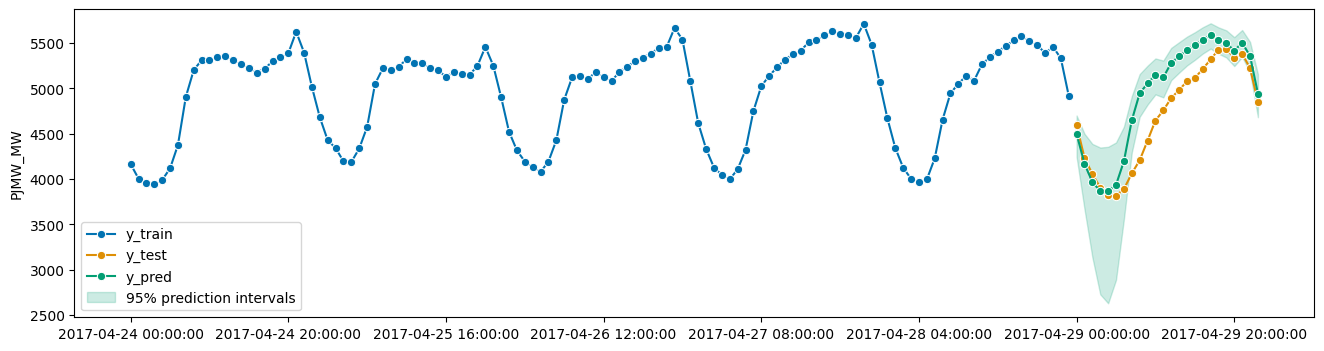

In [115]:
fig, ax = plot_series(y_train, y_test, df_forecast.y_pred, labels=["y_train", "y_test", "y_pred"]);
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    df_forecast["ci_lower"],
    df_forecast["ci_upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"95% prediction intervals",
)
ax.legend(loc='lower left');

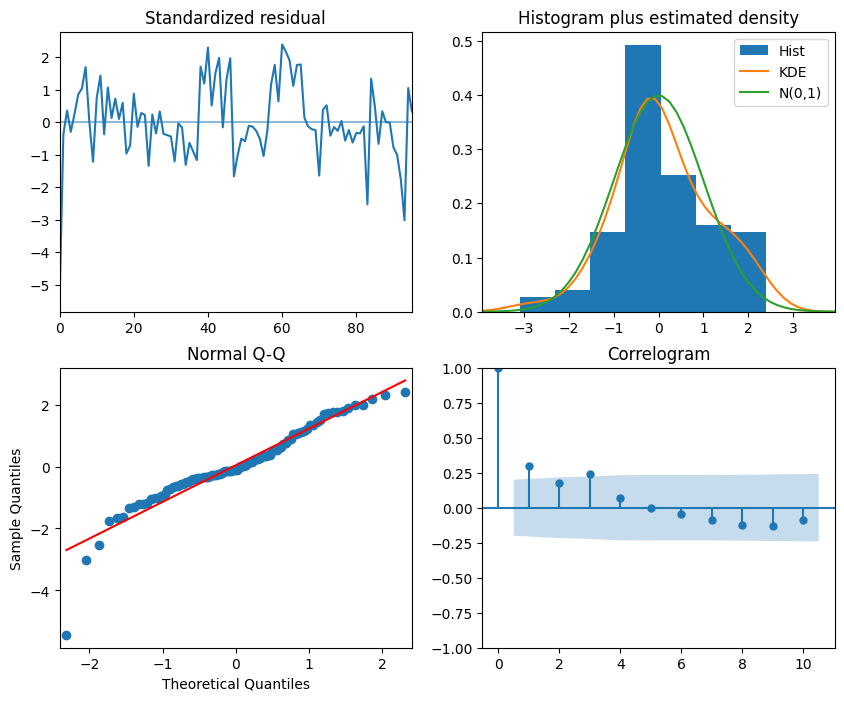

In [116]:
pipeline.steps[1][1].plot_diagnostics(figsize=(10, 8));

## Материалы: 

- [Документация пакета pmdarima с примерами использования](https://alkaline-ml.com/pmdarima/quickstart.html)
- [Гайд по ARIMA от statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html)